# Hidden Markov Model (HMM) Analysis
## Algorithm Appreciation & Aversion in Triadic Delegation Settings

This notebook estimates a **covariate-driven HMM** on the panel-manager-period data:
- **Emission model**: Gaussian on `ai_decision_authority_share` and `override_rate`
- **Transition model**: Multinomial logit driven by performance benchmarks
- **Controls**: Task complexity, demand volatility, etc.

---

### Table of Contents

1. [Helpers & Imports](#1-helpers--imports)
2. [Benchmark Construction](#2-benchmark-construction)
3. [Data Loading & Inspection](#3-data-loading--inspection)
4. [Parameter Structure & Forward-Backward Algorithm](#4-parameter-structure--forward-backward-algorithm)
5. [MLE Fitting & Model Selection](#5-mle-fitting--model-selection)
6. [Estimated Parameters (Best Model)](#6-estimated-parameters-best-model)
7. [Posterior State Assignment](#7-posterior-state-assignment)
8. [Results Visualisation](#8-results-visualisation)

## 1. Helpers & Imports

In [ ]:
# ============================================================
# 1. Imports & Helpers
# ============================================================
from __future__ import annotations

import os
import time
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from pathlib import Path
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

# ---- resolve data path ----
MANUAL_XLSX_PATH = None
PREFERRED_DATASETS = [
    Path(r"..\triadic_simulation\data\Triadic_Delegation_Dataset_SYNTH_ANALYSIS.xlsx"),
]
DATA_PATH = None
if MANUAL_XLSX_PATH:
    DATA_PATH = Path(MANUAL_XLSX_PATH)
else:
    for p in PREFERRED_DATASETS:
        if p.exists():
            DATA_PATH = p
            break
assert DATA_PATH is not None and DATA_PATH.exists(), \
    f"Data file not found. Tried: {PREFERRED_DATASETS}"
print(f"Data file: {DATA_PATH.resolve()}")


def softmax(z, axis=-1):
    """Numerically stable softmax (works on 1-D vectors and row-wise on 2-D)."""
    z = z - np.max(z, axis=axis, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=axis, keepdims=True)


def log_softmax(z, axis=-1):
    """Numerically stable log-softmax."""
    return z - logsumexp(z, axis=axis, keepdims=True)


def log_gaussian_diag(y, mean, log_sigma):
    """Scalar version (kept for reference)."""
    sigma2 = np.exp(2 * log_sigma)
    return -0.5 * (
        np.sum(np.log(2 * np.pi * sigma2))
        + np.sum((y - mean) ** 2 / sigma2)
    )

print("Section 1 — Imports & helpers loaded.")

## 2. Benchmark Construction
Derive performance benchmarks used as **transition covariates**:
- `kpi_operational_gap_index` — composite KPI gap
- `within_unit_temporal_benchmark` — period-over-period change
- `horizontal_peer_benchmark` — cross-sectional percentile
- `within_unit_ai_trajectory_benchmark` — deviation from low-AI baseline
- `threshold_benchmark` — recent negative shock indicator

In [ ]:
# ============================================================
# 2. Build Benchmarks
# ============================================================

def build_benchmarks(df):
    df = df.sort_values(["manager_id", "period_id"]).copy()

    # Composite performance index (higher = better)
    df["kpi_operational_gap_index"] = (
        (-1.0) * df["service_level_delta"]
        + (-0.6) * df["inventory_cost_delta"]
        + (-0.4) * df["expedite_cost_delta"]
        + (-1.2) * df["error_incident_count"]
    )

    # Within-manager temporal benchmark
    df["within_unit_temporal_benchmark"] = (
        df.groupby("manager_id")["kpi_operational_gap_index"].diff(1)
    )

    # Peer percentile (cross-sectional)
    pct = df.groupby("period_id")["kpi_operational_gap_index"].rank(pct=True)
    df["horizontal_peer_benchmark"] = (pct - 0.5) * 2.0

    # AI trajectory benchmark
    def ai_traj(g):
        q = g["ai_decision_authority_share"].quantile(0.30)
        base = g.loc[
            g["ai_decision_authority_share"] <= q,
            "kpi_operational_gap_index",
        ].mean()
        if np.isnan(base):
            base = g["kpi_operational_gap_index"].mean()
        return g["kpi_operational_gap_index"] - base

    df["within_unit_ai_trajectory_benchmark"] = (
        df.groupby("manager_id", group_keys=False).apply(ai_traj)
    )

    # Threshold shock
    df["threshold_benchmark"] = df["recent_negative_shock"].astype(float)

    # Transparency constant (analysis dataset — no variation)
    df["transparency_moderator"] = 0.0

    return df

print("Section 2 — build_benchmarks() defined.")

Section 2 — build_benchmarks() defined.


## 3. Data Loading & Inspection
Load the `panel_manager_period` sheet, build benchmarks, scale variables, and form per-manager sequences.

In [ ]:
# ============================================================
# 3. Data Loader
# ============================================================

@dataclass
class HMMData:
    Y: List[np.ndarray]      # emission sequences
    X: List[np.ndarray]      # transition covariates
    Z: List[np.ndarray]      # emission controls
    ids: List[str]
    periods: List[np.ndarray]
    y_scaler: StandardScaler
    x_scaler: StandardScaler
    z_scaler: StandardScaler


def load_sequences(xlsx_path):
    df = pd.read_excel(xlsx_path, sheet_name="panel_manager_period")

    # Safety: analysis file should NOT contain latent truth columns
    forbidden = ["latent_state_true", "latent_state_true_next"]
    if any(c in df.columns for c in forbidden):
        raise ValueError("Use *_ANALYSIS.xlsx dataset (latent states removed).")

    df = build_benchmarks(df)

    emission_cols = ["ai_decision_authority_share", "override_rate"]

    transition_cols = [
        "within_unit_temporal_benchmark",
        "horizontal_peer_benchmark",
        "within_unit_ai_trajectory_benchmark",
        "threshold_benchmark",
        "transparency_moderator",
    ]

    control_cols = [
        "task_complexity_index",
        "demand_volatility",
        "supply_disruption_count",
        "forecast_accuracy_mape",
        "decision_latency_avg",
        "target_difficulty",
        "performance_pressure_index",
        "recent_negative_shock",
    ]

    df = df.dropna(subset=emission_cols + transition_cols + control_cols)

    Y_list, X_list, Z_list = [], [], []
    ids, periods = [], []

    for mid, g in df.groupby("manager_id"):
        g = g.sort_values("period_id")
        Y = g[emission_cols].to_numpy(float)
        X = g[transition_cols].to_numpy(float)
        Z = g[control_cols].to_numpy(float)
        if len(Y) < 3:
            continue
        Y_list.append(Y)
        X_list.append(X)
        Z_list.append(Z)
        ids.append(mid)
        periods.append(g["period_id"].to_numpy())

    y_scaler = StandardScaler().fit(np.vstack(Y_list))
    x_scaler = StandardScaler().fit(np.vstack(X_list))
    z_scaler = StandardScaler().fit(np.vstack(Z_list))

    Y_list = [y_scaler.transform(y) for y in Y_list]
    X_list = [x_scaler.transform(x) for x in X_list]
    Z_list = [z_scaler.transform(z) for z in Z_list]

    return HMMData(Y_list, X_list, Z_list, ids, periods,
                   y_scaler, x_scaler, z_scaler)


# ---- Load & inspect ----
data = load_sequences(DATA_PATH)

seq_lens = [len(y) for y in data.Y]
print(f"Managers loaded : {len(data.Y)}")
print(f"Total observations: {sum(seq_lens)}")
print(f"Sequence lengths : min={min(seq_lens)}, median={int(np.median(seq_lens))}, max={max(seq_lens)}")
print(f"Emission dims (D) : {data.Y[0].shape[1]}")
print(f"Trans. covars (P) : {data.X[0].shape[1]}")
print(f"Controls (K)      : {data.Z[0].shape[1]}")

Managers loaded : 120
Total observations: 3000
Sequence lengths : min=25, median=25, max=25
Emission dims (D) : 2
Trans. covars (P) : 5
Controls (K)      : 8


## 4. Parameter Structure & Forward-Backward Algorithm

In [ ]:
# ============================================================
# 4. Parameters + Forward–Backward  (VECTORIZED)
# ============================================================

@dataclass
class Params:
    logit_pi: np.ndarray   # (J,)
    alpha: np.ndarray      # (J, J)
    beta: np.ndarray       # (J, J, P)
    mu: np.ndarray         # (J, D)
    W: np.ndarray          # (J, D, K)
    log_sigma: np.ndarray  # (J, D)


def _precompute(p, Y, X, Z):
    """Shared emission + transition pre-computation."""
    T, D = Y.shape
    J = p.mu.shape[0]
    means = p.mu[None, :, :] + np.einsum('jdk,tk->tjd', p.W, Z)
    residuals = Y[:, None, :] - means
    sigma2 = np.exp(2 * p.log_sigma)
    log_norm = np.sum(np.log(2 * np.pi * sigma2), axis=1)
    logB = -0.5 * (log_norm[None, :] +
                   np.sum(residuals ** 2 / sigma2[None, :, :], axis=2))
    logits_all = (p.alpha[None, :, :]
                  + np.einsum('ijp,tp->tij', p.beta, X))
    logQ_all = log_softmax(logits_all, axis=2)
    return T, J, logB, logQ_all


def forward_only(p, Y, X, Z):
    """Forward pass only — returns log-likelihood (no posterior). ~2× faster."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    return float(logsumexp(log_alpha[-1]))


def forward_backward(p, Y, X, Z):
    """Full forward–backward returning (ll, log_gamma)."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    ll = logsumexp(log_alpha[-1])

    log_beta = np.zeros((T, J))
    for t in reversed(range(T - 1)):
        log_beta[t] = logsumexp(
            logQ_all[t + 1] + logB[t + 1][None, :] + log_beta[t + 1][None, :],
            axis=1)

    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    return ll, log_gamma

print("Section 4 — Params, forward_only() & forward_backward() defined.")

Section 4 — Params, forward_only() & forward_backward() defined.


## 5. MLE Fitting & Model Selection
Estimate models with $J \in \{2, 3, 4\}$ hidden states and select the best by **BIC**.

In [ ]:
# ============================================================
# 5. MLE Fitting & Model Selection (BIC)  — FULLY BATCHED
# ============================================================

# Pre-stack all sequences (all same length → 3-D tensors)
Y_stack = np.stack(data.Y)   # (N, T, D)
X_stack = np.stack(data.X)   # (N, T, P)
Z_stack = np.stack(data.Z)   # (N, T, K)
N, T, D = Y_stack.shape
P = X_stack.shape[2]
K = Z_stack.shape[2]
n_obs_total = N * T
print(f"Batched: {N} managers × {T} periods  (D={D}, P={P}, K={K})")


def fit_model_batched(J=3, maxiter=800):
    rng = np.random.default_rng(7)
    p0 = Params(
        logit_pi=rng.normal(0, 0.1, J),
        alpha=rng.normal(0, 0.1, (J, J)),
        beta=rng.normal(0, 0.05, (J, J, P)),
        mu=rng.normal(0, 0.5, (J, D)),
        W=rng.normal(0, 0.05, (J, D, K)),
        log_sigma=np.zeros((J, D)),
    )

    def pack(p):
        return np.concatenate([
            p.logit_pi.ravel(), p.alpha.ravel(), p.beta.ravel(),
            p.mu.ravel(), p.W.ravel(), p.log_sigma.ravel(),
        ])

    def unpack(theta):
        idx = 0
        def take(n):
            nonlocal idx; v = theta[idx:idx+n]; idx += n; return v
        return Params(
            take(J), take(J*J).reshape(J,J),
            take(J*J*P).reshape(J,J,P), take(J*D).reshape(J,D),
            take(J*D*K).reshape(J,D,K), take(J*D).reshape(J,D),
        )

    # Fully batched objective — no Python loop over managers
    def objective(theta):
        p = unpack(theta)
        # Emissions  (N, T, J)
        means = p.mu[None, None, :, :] + np.einsum('jdk,ntk->ntjd', p.W, Z_stack)
        resid = Y_stack[:, :, None, :] - means
        sigma2 = np.exp(2 * p.log_sigma)
        log_norm = np.sum(np.log(2 * np.pi * sigma2), axis=1)
        logB = -0.5 * (log_norm[None, None, :] +
                       np.sum(resid ** 2 / sigma2[None, None, :, :], axis=3))

        # Transitions  (N, T, J, J)
        logQ = log_softmax(
            p.alpha[None, None, :, :] + np.einsum('ijp,ntp->ntij', p.beta, X_stack),
            axis=3)

        # Forward pass — loop over T only, fully vectorized over N managers
        la = np.log(softmax(p.logit_pi))[None, :] + logB[:, 0, :]   # (N, J)
        for t in range(1, T):
            la = logB[:, t, :] + logsumexp(la[:, :, None] + logQ[:, t], axis=1)

        return -float(np.sum(logsumexp(la, axis=1)))

    res = minimize(objective, pack(p0), method="L-BFGS-B",
                   options={"maxiter": maxiter, "disp": False})
    return unpack(res.x), res


# ---- Run model selection ----
results = []
best_model, best_J, best_bic = None, None, np.inf

for J in [2, 3, 4]:
    print(f"Fitting J={J} ... ", end="", flush=True)
    t0 = time.time()
    p_hat, res = fit_model_batched(J=J, maxiter=100)
    elapsed = time.time() - t0

    ll_total = -res.fun
    k = len(res.x)
    bic = np.log(n_obs_total) * k - 2 * ll_total
    aic = 2 * k - 2 * ll_total
    results.append({"J": J, "params": k, "LL": ll_total, "AIC": aic,
                     "BIC": bic, "converged": res.success, "time_s": elapsed})
    print(f"LL={ll_total:.1f}  BIC={bic:.1f}  params={k}  "
          f"{'✓' if res.success else '✗'}  ({elapsed:.1f}s)")

    if bic < best_bic:
        best_bic, best_model, best_J = bic, p_hat, J

print(f"\n★ Best model: J={best_J}  (BIC={best_bic:.1f})")

sel_df = pd.DataFrame(results)
sel_df = sel_df.round({"LL": 1, "AIC": 1, "BIC": 1, "time_s": 1})
display(sel_df)

Batched: 120 managers × 25 periods  (D=2, P=5, K=8)
Fitting J=2 ... 

C:\Users\Admin\AppData\Local\Temp\ipykernel_6640\626491112.py:66: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective, pack(p0), method="L-BFGS-B",


LL=1678.1  BIC=-2827.8  params=66  ✗  (73.8s)
Fitting J=3 ... LL=3616.3  BIC=-6295.9  params=117  ✗  (181.9s)
Fitting J=4 ... LL=3903.4  BIC=-6365.6  params=180  ✗  (245.0s)

★ Best model: J=4  (BIC=-6365.6)


,J,params,LL,AIC,BIC,converged,time_s
0,2,66,1678.1,-3224.2,-2827.8,False,73.8
1,3,117,3616.3,-6998.7,-6295.9,False,181.9
2,4,180,3903.4,-7446.8,-6365.6,False,245.0


## 6. Estimated Parameters (Best Model)
Print the emission means, standard deviations, initial state distribution, and transition intercepts for the selected model.

In [ ]:
# ============================================================
# 6. Inspect Estimated Parameters
# ============================================================

emission_cols = ["ai_decision_authority_share", "override_rate"]

# Un-standardise emission means & sigmas for interpretation
mu_orig = data.y_scaler.inverse_transform(best_model.mu)
sigma_orig = np.exp(best_model.log_sigma) * data.y_scaler.scale_

print(f"Best model: J={best_J} hidden states\n")

# Emission parameters
em_rows = []
for j in range(best_J):
    for d, col in enumerate(emission_cols):
        em_rows.append({
            "State": j + 1,
            "Variable": col,
            "Mean (orig scale)": round(mu_orig[j, d], 4),
            "Std (orig scale)": round(sigma_orig[j, d], 4),
        })
em_df = pd.DataFrame(em_rows)
print("── Emission Parameters ──")
display(em_df)

# Initial-state distribution
pi = softmax(best_model.logit_pi)
print("\n── Initial State Distribution ──")
for j in range(best_J):
    print(f"  π(state {j+1}) = {pi[j]:.4f}")

# Transition intercepts
print("\n── Transition Intercept Matrix (α) ──")
alpha_df = pd.DataFrame(
    np.round(best_model.alpha, 3),
    index=[f"from {j+1}" for j in range(best_J)],
    columns=[f"to {j+1}" for j in range(best_J)])
display(alpha_df)

Best model: J=4 hidden states

── Emission Parameters ──


,State,Variable,Mean (orig scale),Std (orig scale)
0,1,ai_decision_authority_share,0.4038,0.0212
1,1,override_rate,0.5959,0.0214
2,2,ai_decision_authority_share,0.5211,0.0662
3,2,override_rate,0.4811,0.0658
4,3,ai_decision_authority_share,0.5009,0.0202
5,3,override_rate,0.4992,0.0203
6,4,ai_decision_authority_share,0.4388,0.0145
7,4,override_rate,0.5617,0.0141



── Initial State Distribution ──
  π(state 1) = 0.2541
  π(state 2) = 0.2443
  π(state 3) = 0.2534
  π(state 4) = 0.2483

── Transition Intercept Matrix (α) ──


,to 1,to 2,to 3,to 4
from 1,0.240,-0.726,0.133,0.348
from 2,-0.220,-0.015,0.014,0.195
from 3,0.107,-0.595,0.148,0.324
from 4,-0.031,-0.729,0.000,0.261


## 7. Posterior State Assignment
Run the forward-backward on every manager with the best model and produce a posterior CSV file.

In [ ]:
# ============================================================
# 7. Posterior State Assignment
# ============================================================

rows = []
for mid, periods, Y, X, Z in zip(data.ids, data.periods,
                                   data.Y, data.X, data.Z):
    ll, log_gamma = forward_backward(best_model, Y, X, Z)
    gamma = np.exp(log_gamma)
    states = gamma.argmax(axis=1) + 1
    for t in range(len(Y)):
        row = {"manager_id": mid, "period_id": periods[t],
               "most_likely_state": states[t]}
        for j in range(gamma.shape[1]):
            row[f"posterior_state_{j+1}"] = gamma[t, j]
        rows.append(row)

posteriors = pd.DataFrame(rows)

out_path = Path("hmm_posteriors.csv")
posteriors.to_csv(out_path, index=False)
print(f"Posterior file saved → {out_path.resolve()}")
print(f"Shape: {posteriors.shape}")
display(posteriors.head(10))

# State frequency
print("\n── State Frequency ──")
freq = posteriors["most_likely_state"].value_counts().sort_index()
for s, n in freq.items():
    print(f"  State {s}: {n:,} obs ({n/len(posteriors)*100:.1f}%)")

Posterior file saved → C:\Users\Admin\OneDrive\Desktop\Algorithm-Appreciation-and-Aversion-in-Triadic-Delegation-Settings\data_analysis\hmm_posteriors.csv
Shape: (3000, 7)


,manager_id,period_id,most_likely_state,posterior_state_1,posterior_state_2,posterior_state_3,posterior_state_4
0,M0001,2,4,5.746959e-06,0.066977,1.056460e-01,8.273717e-01
1,M0001,3,4,2.689908e-03,0.000562,1.688627e-04,9.965790e-01
2,M0001,4,1,9.983401e-01,0.001660,6.594693e-17,1.754351e-13
3,M0001,5,3,2.642002e-08,0.055598,8.339135e-01,1.104881e-01
4,M0001,6,3,1.136410e-06,0.026159,5.546736e-01,4.191659e-01
5,M0001,7,2,7.332258e-11,0.999907,6.366188e-31,9.271047e-05
6,M0001,8,1,7.263199e-01,0.101666,6.508320e-08,1.720136e-01
7,M0001,9,3,1.692688e-01,0.113400,7.173314e-01,2.446499e-17
8,M0001,10,4,1.335807e-01,0.086204,6.758467e-06,7.802083e-01
9,M0001,11,3,3.969469e-16,0.232191,7.678088e-01,2.018407e-09



── State Frequency ──
  State 1: 829 obs (27.6%)
  State 2: 306 obs (10.2%)
  State 3: 906 obs (30.2%)
  State 4: 959 obs (32.0%)


## 8. Results Visualisation

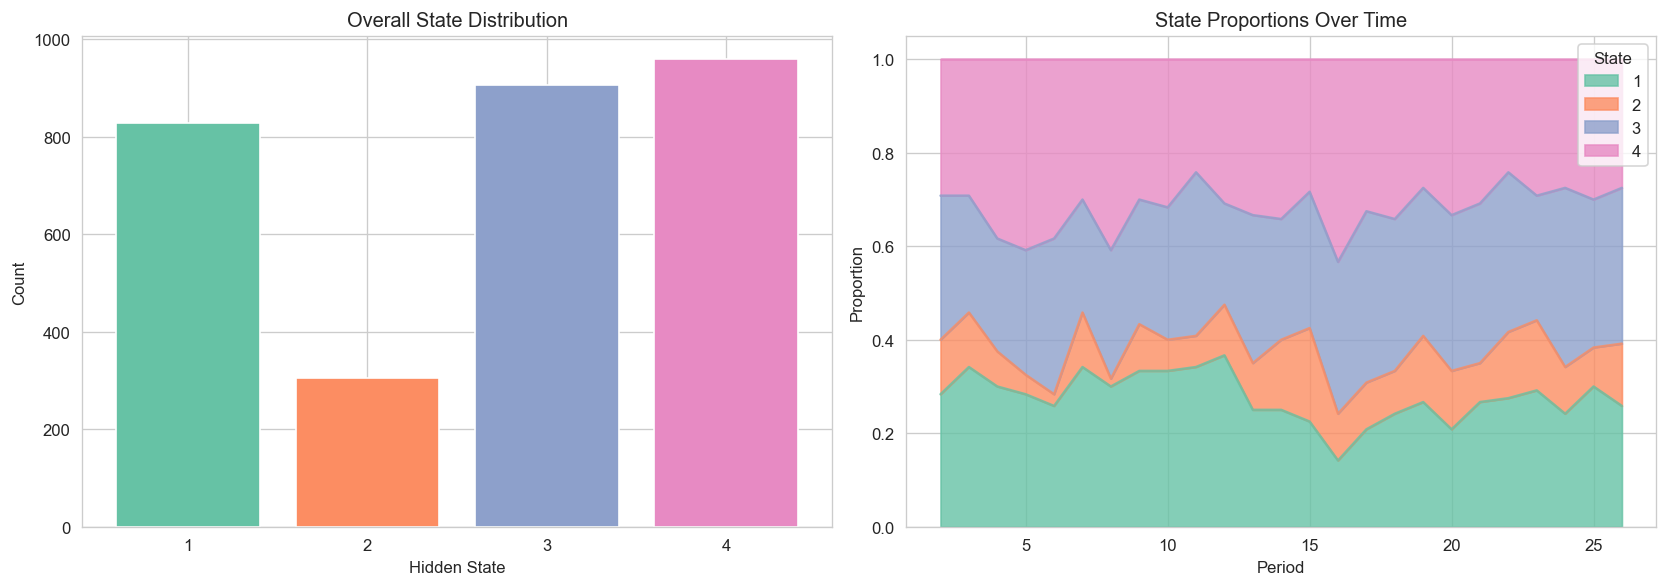

In [ ]:
# ============================================================
# 8a. State distribution over time
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: overall state proportions
freq = posteriors["most_likely_state"].value_counts().sort_index()
axes[0].bar(freq.index.astype(str), freq.values, color=sns.color_palette("Set2", best_J))
axes[0].set_xlabel("Hidden State")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall State Distribution")

# Stacked area: state proportions by period
pivot = (posteriors.groupby(["period_id", "most_likely_state"])
         .size().unstack(fill_value=0))
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
pivot_pct.plot.area(ax=axes[1], stacked=True, alpha=0.8,
                     color=sns.color_palette("Set2", best_J))
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Proportion")
axes[1].set_title("State Proportions Over Time")
axes[1].legend(title="State", loc="upper right")

plt.tight_layout()
plt.show()

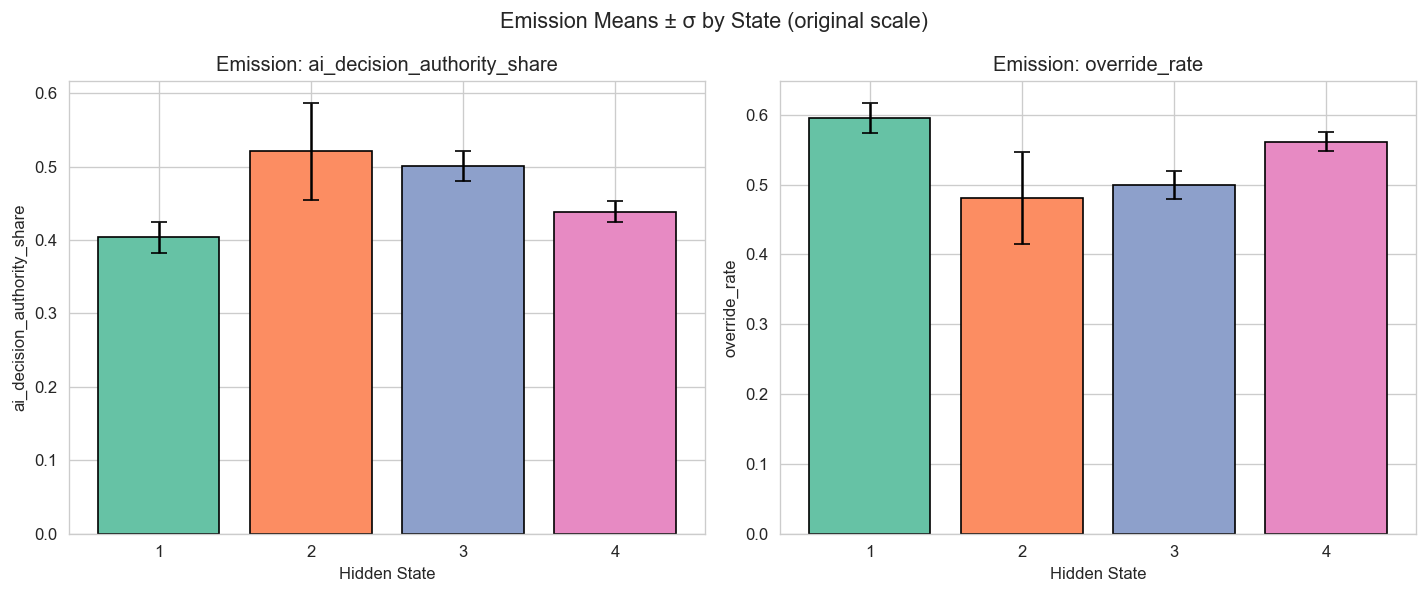

In [ ]:
# ============================================================
# 8b. Emission means by state (original scale)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for d, col in enumerate(emission_cols):
    ax = axes[d]
    vals = [mu_orig[j, d] for j in range(best_J)]
    errs = [sigma_orig[j, d] for j in range(best_J)]
    x = np.arange(best_J) + 1
    ax.bar(x.astype(str), vals, yerr=errs, capsize=5,
           color=sns.color_palette("Set2", best_J), edgecolor="k")
    ax.set_xlabel("Hidden State")
    ax.set_ylabel(col)
    ax.set_title(f"Emission: {col}")

plt.suptitle("Emission Means ± σ by State (original scale)", fontsize=13)
plt.tight_layout()
plt.show()

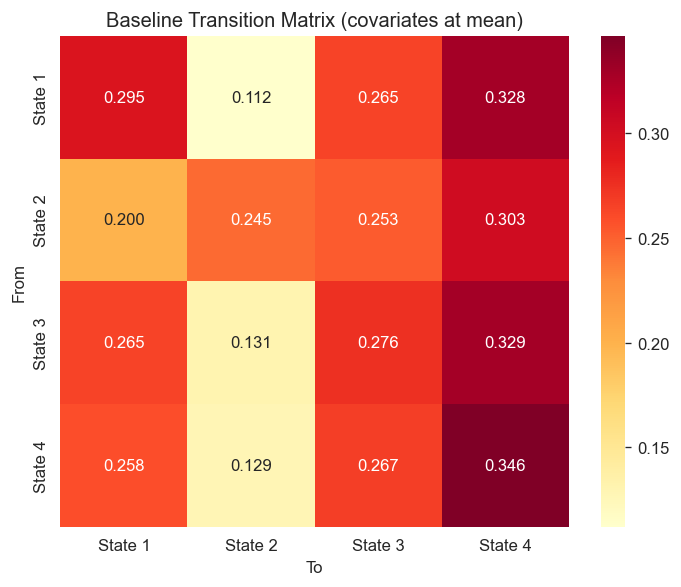


Transition probabilities (rows sum to 1):
  From state 1: [0.295 0.112 0.265 0.328]
  From state 2: [0.200 0.245 0.253 0.303]
  From state 3: [0.265 0.131 0.276 0.329]
  From state 4: [0.258 0.129 0.267 0.346]


In [ ]:
# ============================================================
# 8c. Transition matrix heatmap (baseline, at X=0)
# ============================================================

# Baseline transition matrix (covariates at their mean = 0 after scaling)
Q_base = np.zeros((best_J, best_J))
for k in range(best_J):
    logits = best_model.alpha[k]  # beta @ 0 = 0
    Q_base[k] = softmax(logits)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(Q_base, annot=True, fmt=".3f", cmap="YlOrRd",
            xticklabels=[f"State {j+1}" for j in range(best_J)],
            yticklabels=[f"State {j+1}" for j in range(best_J)],
            ax=ax)
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_title("Baseline Transition Matrix (covariates at mean)")
plt.tight_layout()
plt.show()

print("\nTransition probabilities (rows sum to 1):")
for k in range(best_J):
    probs = " ".join(f"{Q_base[k,j]:.3f}" for j in range(best_J))
    print(f"  From state {k+1}: [{probs}]")

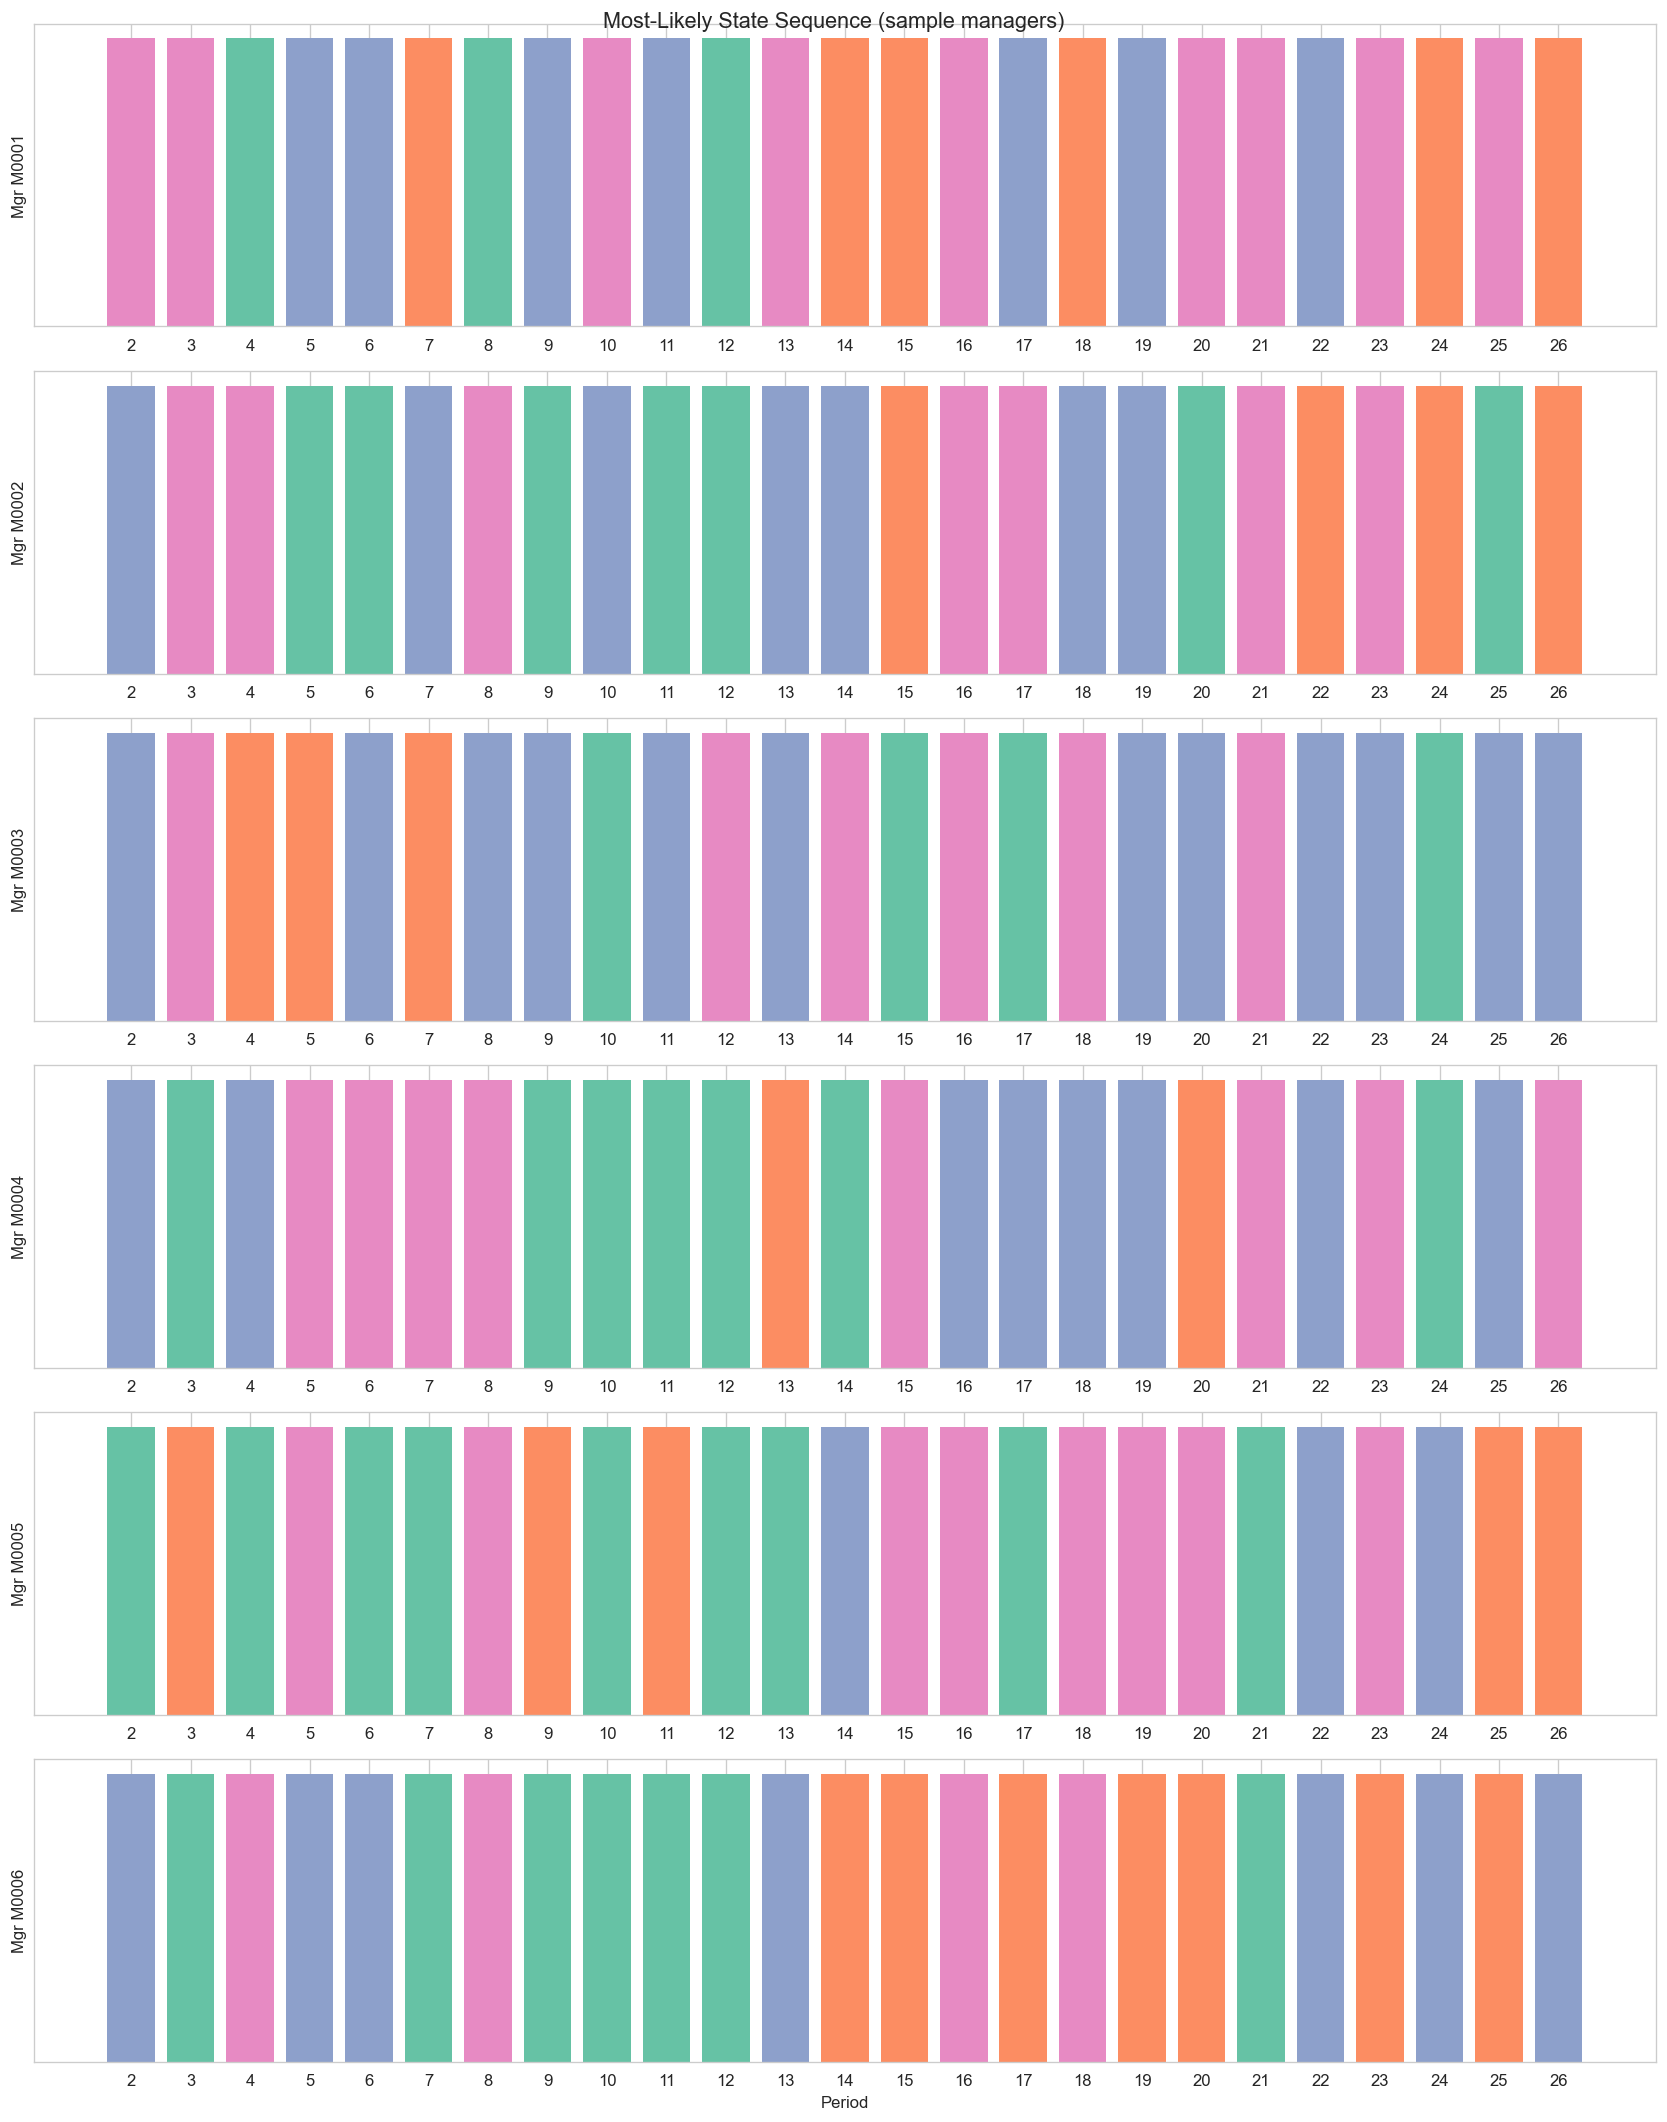

Done — all sections complete.


In [ ]:
# ============================================================
# 8d. Example manager trajectories
# ============================================================

sample_ids = data.ids[:min(6, len(data.ids))]
fig, axes = plt.subplots(len(sample_ids), 1, figsize=(14, 3 * len(sample_ids)),
                          sharex=False)
if len(sample_ids) == 1:
    axes = [axes]

for ax, mid in zip(axes, sample_ids):
    sub = posteriors[posteriors["manager_id"] == mid].sort_values("period_id")
    colors = sns.color_palette("Set2", best_J)
    state_colors = [colors[s - 1] for s in sub["most_likely_state"]]
    ax.bar(sub["period_id"].astype(str), [1]*len(sub), color=state_colors, edgecolor="none")
    ax.set_ylabel(f"Mgr {mid}")
    ax.set_yticks([])

axes[-1].set_xlabel("Period")
plt.suptitle("Most-Likely State Sequence (sample managers)", fontsize=13)
plt.tight_layout()
plt.show()

print("Done — all sections complete.")